In [27]:
from img2vec_pytorch import Img2Vec  # type: ignore
import os
from PIL import Image
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import optuna
import shutil # used for file operations
import random
from sklearn.model_selection import cross_val_score, StratifiedKFold

In [17]:
try:
    import torch
    cuda_available = torch.cuda.is_available()
except Exception:
    cuda_available = False

img2vec = Img2Vec(cuda=cuda_available)  # use GPU only if available

In [18]:
train_dir = './training_set'
test_dir = './test_set'
val_dir = './validation_set'

In [19]:
# if val_dir does not exist, create it by splitting test_dir
if not os.path.exists(val_dir): 
    os.makedirs(val_dir, exist_ok=True)
    

In [20]:
val_split = 0.1
copy_files = False


for category in os.listdir(train_dir):
    category_path = os.path.join(train_dir, category)
    if not os.path.isdir(category_path):
        continue # skip non-directory files

    # create corresponding category folders in validation set
    val_category_path = os.path.join(val_dir, category)
    os.makedirs(val_category_path, exist_ok=True) # create 'cat' 'dog' folders if not exist

    files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    # shuffle to randomise selection
    random.shuffle(files)

    # calculate how many to move / copy
    num_val = int(len(files) * val_split)
    val_files = files[:num_val]

    print(f"📂 {category}: moving {num_val}/{len(files)} images to validation set")
    for file_name in val_files:
        src_path = os.path.join(category_path, file_name)
        dest_path = os.path.join(val_category_path, file_name)
        if copy_files:
            shutil.copy2(src_path, dest_path)  # copy file
        else:
            shutil.move(src_path, dest_path)  # move file

print("✅ Validation set created successfully.")



📂 cat: moving 360/3600 images to validation set
📂 dog: moving 360/3605 images to validation set
✅ Validation set created successfully.


In [21]:
"""Extracts image embeddings using Img2Vec and returns:
        features: 2D numpy array (num_images x embedding_dim)
        labels:   1D numpy array (class names)
"""

def extract_features_n_labels(directory):
    features = [] # will store 1D embeddings vectors for each image
    labels = []   # will store class names for each image

    # loop through each subfolder ('cat' and 'dog')
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        
        # skip if not a folder 
        if not os.path.isdir(category_path):
            continue
        # loop through each image in the subfolder
        for img_name in os.listdir(category_path):

            # only process supported image files
            if not img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            img_path = os.path.join(category_path, img_name)

            try:
                img = Image.open(img_path).convert('RGB')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                continue
            img_vector = img2vec.get_vec(img)  # get 1D embedding vector
            features.append(img_vector)
            labels.append(category)
        
    features = np.vstack(features)  # convert list of vectors to 2D numpy array
    labels = np.array(labels)     
    
    return features, labels   # convert list of labels to 1D numpy array

In [22]:
# building dataset 
train_features, train_labels = extract_features_n_labels(train_dir)
test_features, test_labels = extract_features_n_labels(test_dir)



In [23]:
# Encode string labels to integers — safe for XGBoost and consistent across models
le = LabelEncoder()
train_labels_enc = le.fit_transform(train_labels)
test_labels_enc = le.transform(test_labels)

In [24]:
def objective(trial):
    regressor_name = trial.suggest_categorical('regressor', ['RandomForest', 'SVC', 'XGBClassifier'])

    if regressor_name == 'RandomForest':
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

    elif regressor_name == 'SVC':
        C = trial.suggest_float('C', 1e-6, 1e+1, log=True)
        gamma = trial.suggest_float('gamma', 1e-6, 1e+1, log=True)
        # SVC can be slow on large feature vectors — consider scaling / using a linear kernel for speed
        model = SVC(C=C, gamma=gamma, probability=False, random_state=42)

    else:  # XGBClassifier
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
        n_estimators = trial.suggest_int('n_estimators', 50, 300)
        max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
        model = XGBClassifier(learning_rate=learning_rate,
                              n_estimators=n_estimators,
                              max_depth=max_depth,
                              use_label_encoder=False,
                              eval_metric='mlogloss',
                              random_state=42,
                              n_jobs=1)

    # fit on precomputed train features (encoded labels )
    model.fit(train_features, train_labels_enc)
    preds = model.predict(test_features)

    return accuracy_score(test_labels_enc, preds)

In [25]:
# Run Optuna study to optimize model hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best trial:")
trial = study.best_trial

print(f"  Value: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
    

[I 2025-11-09 13:58:44,691] A new study created in memory with name: no-name-e93e27f2-86db-4e00-b0ea-06b2b5a559a3
d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [13:58:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
[I 2025-11-09 13:58:48,262] Trial 0 finished with value: 0.9757785467128027 and parameters: {'regressor': 'XGBClassifier', 'learning_rate': 0.09349455765457411, 'n_estimators': 71, 'max_depth': 3}. Best is trial 0 with value: 0.9757785467128027.
[I 2025-11-09 13:58:49,246] Trial 1 finished with value: 0.9762728620860108 and parameters: {'regressor': 'RandomForest', 'n_estimators': 127, 'max_depth': 28}. Best is trial 1 with value: 0.9762728620860108.
[I 2025-11-09 13:58:49,633] Trial 2 finished with value: 0.9619377162629758 and parameters: {'regressor': 'RandomForest', 'n_estimators': 191, 'max_depth': 

Best trial:
  Value: 0.9826989619377162
  Params: 
    regressor: XGBClassifier
    learning_rate: 0.11357446062816196
    n_estimators: 196
    max_depth: 3


In [26]:
# Train best model on full training set and evaluate on validation set
best_regressor_name = trial.params['regressor']
if best_regressor_name == 'RandomForest':
    best_model = RandomForestClassifier(n_estimators=trial.params['n_estimators'],
                                        max_depth=trial.params['max_depth'],
                                        random_state=42, n_jobs=-1)
elif best_regressor_name == 'SVC':
    best_model = SVC(C=trial.params['C'], gamma=trial.params['gamma'], random_state=42)
else:
    best_model = XGBClassifier(learning_rate=trial.params['learning_rate'],
                               n_estimators=trial.params['n_estimators'],
                               max_depth=trial.params['max_depth'],
                               use_label_encoder=False,
                               eval_metric='mlogloss',
                               random_state=42)
    
# fit on precomputed train features (encoded labels )
best_model.fit(train_features, train_labels_enc)
best_preds = best_model.predict(test_features)
best_accuracy = accuracy_score(test_labels_enc, best_preds)
print(f"Validation Accuracy of best model: {best_accuracy:.4f}")

d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:02:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Validation Accuracy of best model: 0.9827


In [28]:
# cross-Valdidation 
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_score = cross_val_score(best_model, train_features, train_labels_enc, cv=cv, scoring='accuracy')


d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\training.py:199: UserWarning: [14:29:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:7

In [30]:

print("📊 Cross-validation accuracies:", cv_score)
print("✅ Mean CV accuracy:", np.mean(cv_score))
print("📈 Std deviation:", np.std(cv_score))

📊 Cross-validation accuracies: [0.9768697  0.98380879 0.98689283 0.9845798  0.97455667]
✅ Mean CV accuracy: 0.9813415574402466
📈 Std deviation: 0.004762820419886048


d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "d:\vs code\OpenCV\Projects\Project3\myvenv\Lib\site-packages\xgboost\sklearn.py", line 1803, in fit
    sel

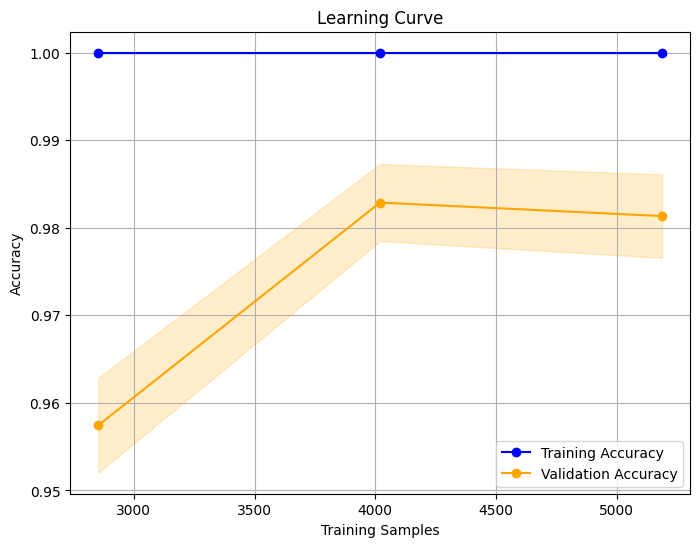

In [31]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, train_features, train_labels_enc,
    cv=cv, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, val_mean, 'o-', color='orange', label='Validation Accuracy')
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, color='orange', alpha=0.2)
plt.title("Learning Curve")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.grid()
plt.show()


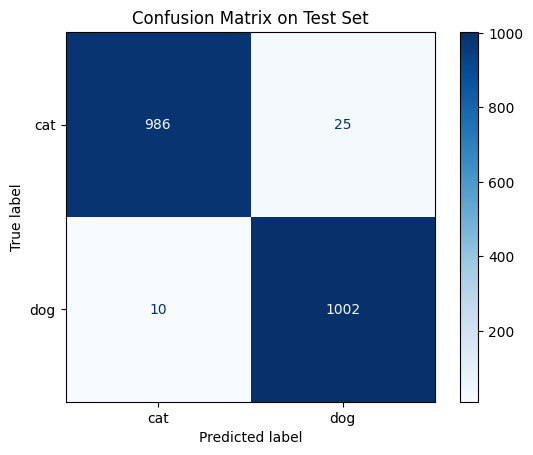

In [32]:
# Confusion Matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

preds = best_model.predict(test_features)
cm = confusion_matrix(test_labels_enc, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()
